# Natural Language Processing with Python
### Harvard DataFest 2020

Elizabeth Piette, PhD MPH

Statistician/Data Scientist

Research Computing Services, DRFD, Harvard Business School

617-495-1226

epiette@hbs.edu

# Introductions

Please share your name and a few words about your background.

Why are you interested in this workshop?

# What is natural language processing (NLP)?

NLP is a field that focuses on how computers can be used to process, analyze, and represent **natural language**.

A natural language is one that has evolved organically, as opposed to a language that has been constructed intentionally (such as a programming language like Python, or an auxiliary language like Esperanto).

**Discussion: what makes natural language difficult to model?**

A funny example: https://www.ling.upenn.edu/~beatrice/humor/headlines.html

Over time, NLP has shifted from hand-written rules to machine learning algorithms. 

**Discussion: what are some of the advantages and disadvantages of rules-based versus machine learning approaches?**

# How do we utilize NLP in our daily lives?

Basically whenever we use text or speech to interact with computers, phones, or smart devices:

* Search engines
* Question answering chat bots
* Autocorrect, autocomplete
* Virtual assistants
* Machine translation

# Our motivating problem:

Your best friend's birthday is next week, and you want to give her something she'll really appreciate.  You know she's read all of Emily Dickinson's poems and wishes there were more, so why not try writing a poem in Dickinson's style?

After a few sad attempts, it's beginning to look like you're not much of a poet.  But you have been developing your Python skills and want to learn more about NLP... perhaps you could *generate* a poem?  This could be the perfect opportunity to make a thoughtful gift for your friend and develop some new skills at the same time!

# Acquiring a corpus

This is one of the most important parts of an NLP project, and should be informed by your task.

Some questions you may ask yourself before you assemble your corpus:
* Should our corpus texts come from a specific domain?  Words have different meanings in different contexts
* Do the corpus documents consist of natural language, tables, lists, ...? How will I consolidate or separate these? Do I need to write custom parsers?
* Does the text come from a database, word doc, pdf, web page, ...? Multiple sources?
* Is there any meaningful text formatting - italics, bold, underline, ...? Should I utilize this, and how?
* Do I need annotated data?  How will I define the annotation guidelines, and who will perform the annotation?

**Discussion: what kind of corpora would we want for the applications above?**

**Discussion: what would our ideal corpus look like?**

# Loading necessary libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
import unicodedata
import re
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from IPython.display import Image

# Scraping text from the web

We're going to start our project in the way that many NLP projects start - by scraping web pages.

First, we’ll compile a list of URLs for the pages we’d like to scrape to assemble our corpus:

* Visit https://en.wikipedia.org/wiki/List_of_Emily_Dickinson_poems
* Right-click a link in the table from the **First Line** column 
* Click **Inspect**
* Links are defined in HTML using the **a** tag
* The URL addresses of the links we want are in the **href** attribute
* The **class** attribute distinguishes different categories of links
* Use **requests** to get the page text and **BeautifulSoup** to get the URLs

Requests documentation: https://requests.readthedocs.io/en/master/

BeautifulSoup documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [ ]:
dickinson_poems = 'https://en.wikipedia.org/wiki/List_of_Emily_Dickinson_poems'

r = requests.get(dickinson_poems)

soup = BeautifulSoup(r.text)
print(soup.prettify())

Now that we've identified how links are represented, let's take all of these links and put them in a list. We can do this using a **list comprehension**:

In [ ]:
links = [link.get('href') for link in soup.findAll('a', {'class': 'extiw'})]

It's always a good idea to look at your data as a sanity check, so let's peak at the first 10 and last 10 lines in our list of links:

In [ ]:
links[:10]

In [ ]:
links[-10:]

The last link isn't to a poem, so let's remove that:

In [ ]:
del links[-1]

Next, we'll visit each of these pages and extract the poem text:

* Visit one of the links in the table, such as https://en.wikisource.org/wiki/A_Bee_his_burnished_Carriage
* Right click the poem text and click **Inspect**
* Identify the HTML tags and attributes for the element containing the poem
* Write a function to scrape our desired corpus using **requests** and **BeautifulSoup**

Here's the page content of the first link:

In [ ]:
r = requests.get(links[0])

soup = BeautifulSoup(r.text)

soup

Now that we've found the appropriate tags associated with the poem, we can go ahead and grab the poem text:

In [ ]:
poem = soup.find('div', {'class': 'poem'})
poem.text

The following cell combines the steps we performed above into a function that returns the scraped poems from the list of URLs. We'll skip calling this in the interest of time.

```python
def scrape_corpus(corpus_URLs: list) -> list:

    """
    Takes our list of URLS
    Returns a list of the poems scraped from those pages
    """

    corpus = []

    for link in corpus_URLs:
        r = requests.get(link)
        soup = BeautifulSoup(r.text)
        poem = soup.find('div', {'class': 'poem'})
            
        if poem is not None:
            corpus.append(poem.text)

    return [unicodedata.normalize('NFKD', poem) for poem in corpus]

corpus_texts = scrape_corpus(links)
```

For those interested, this is how I saved the corpus:

```python
joined_corpus = '\p'.join(corpus_texts)

with open('corpus.txt', 'w', encoding='utf-8') as f:
    f.write(joined_corpus)
```

Note that this doesn't do a perfect job of extracting the content we want - for example, some of the text we extracted has multiple versions of a given poem.  Encountering inconsistencies in page HTML formatting is very common in web scraping tasks. You can perform some manual or automated checks and cleaning as desired/as is feasible.  This is generally an iterative process.

Now we'll just load the corpus I saved prior to this workshop:

In [ ]:
with open('../data/corpus.txt', 'r', encoding='utf-8') as f:
    corpus_texts = f.read()

corpus_texts = corpus_texts.split('\p')

corpus_texts[0]

In [ ]:
len(corpus_texts)

# Pre-processing

*Garbage in, garbage out*

Pre-processing is going to turn the raw text we scraped from the web into **data**.

Basic preprocessing often includes:
* Tokenization
* Removing capitalization
* Stripping away tags
* Removing accents/special characters
* Removing punctuation
* Removing/normalizing whitespace
* Stemming/lemmatization
* Removing stopwords

Once again, the way in which you pre-process your data should be informed by your final application - there isn't a one-size-fits-all approach.  For example:
* Capitalization may be informative (Apple vs. apple)
* HTML tags may provide structural information/metadata we can use as features or to label data
* Sentence tokenization may need to be performed differently for different types of texts, eg in social media texts there may be punctuation missing from the ends of sentences, but additional punctuation forming emojis :)
* Word tokenization may also depend on the source text, eg in text formatted for newspapers there may be hyphens separating words between syllables across lines due to column formatting

**Discussion: what types of pre-processing do you think would be more appropriate for our application?**

For this workshop, we're going to lowercase all text, remove all punctuation, and perform line and word tokenization. Let's start by investigating the output each of these types of pre-processing separately.

We can make our text lowercase using **.lower()**, which is a built in **String** method in Python. For example, let's lower everything in the first poem in our corpus:

In [ ]:
corpus_texts[0].lower()

We can remove punctuation using a **regular expression**. It's okay if you're not familiar with regular expressions yet, but you may want to learn more about them as you go forth in your NLP journey since they allow you to specify text search patterns.

The code below finds all characters in our specified text (in this case, corpus_texts[0], the first poem) that are not "word characters" or whitespace, and substitutes them with an empty string.

In [ ]:
re.sub(r'[^\w\s]','', corpus_texts[0])

**NLTK** is going to become your favorite tool, and is accompanied by an excellent book that you can work through to expand your repertoire far beyond what we can cover in the scope of this workshop.
* https://www.nltk.org/
* https://www.nltk.org/book/

**NLTK** has a built in **sentence tokenizer**, but since our poems don't consist of sentences in the traditional sense, we can perform our own **line tokenization** by splitting on newlines:

In [ ]:
corpus_texts[0].split('\n')

We can perform **word tokenization** using the **NLTK word tokenizer**:

In [ ]:
from nltk import word_tokenize
word_tokenize(corpus_texts[0])

Now, let's write a function that combines our four preprocessing steps. 

In [ ]:
#Example solution:

def preprocess_poem(poem: str) -> list:

    """
    Takes a poem (as a single string)
    Returns the poem lowercased, with punctuation removed, line and word tokenized
    (as a list of lists, where each line is a list of words)
    """

    poem = poem.lower()
    poem = re.sub(r'[^\w\s]','', poem)
    poem = poem.split('\n')
    poem = [word_tokenize(line) for line in poem]
    
    return poem

Writing docstrings makes life easier for others reading, reusing, and modifying your code (including future-you)

In [ ]:
help(preprocess_poem)

In [ ]:
preprocess_poem(corpus_texts[0])

Looks pretty good! But let's also remove these extraneous empty lines:

In [ ]:
def preprocess_poem(poem: str) -> list:

    """
    Takes a poem (as a single string)
    Returns the poem lowercased, with punctuation removed, line and word tokenized
    (as a list of lists, where each line of the poem is a list of words)
    """

    poem = poem.lower()
    poem = re.sub(r'[^\w\s]','', poem)
    poem = poem.split('\n')
    poem = [word_tokenize(line) for line in poem if line]
    
    return poem

In [ ]:
preprocess_poem(corpus_texts[0])

Great! Now let's apply our preprocessing to the entire corpus:

In [ ]:
preprocessed_poems = [preprocess_poem(poem) for poem in corpus_texts]

# Exploring our data

Now that we've performed some pre-processing, we can more readily explore our data. In order get some distributional statistics, it'll make our lives easier to first join the entire pre-processed corpus into one long list:

In [ ]:
joined_lines = [line for poem in preprocessed_poems for line in poem]
joined_corpus = [word for line in joined_lines for word in line]

In [ ]:
joined_corpus[:10]

Now we can do some basic counts:

In [ ]:
print('There are {} total words in the corpus'.format(len(joined_corpus)))
print('There are {} unique words in the corpus'.format(len(set(joined_corpus))))

We can also use **NLTK** to look at word frequencies. Let's take a look at the 10 most common words in our corpus:

In [ ]:
from nltk.probability import FreqDist

fdist = FreqDist(joined_corpus)

fdist.most_common(10)

The most common words in the corpus are not very exciting...

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

english_stopwords = nltk.corpus.stopwords.words('english')
english_stopwords[:10]

Let's write a function to remove **stopwords**:

In [ ]:
def remove_nltk_stopwords(tokenized_corpus: list, stopwords: list) -> list:
    
    """
    Takes a list of tokens and a list of stopwords
    Returns the list of tokens with stopwords removed
    """

    return [token for token in tokenized_corpus if token not in stopwords]

In [ ]:
joined_corpus_stopwords_removed = remove_nltk_stopwords(joined_corpus, english_stopwords)

fdist = FreqDist(joined_corpus_stopwords_removed)

fdist.most_common(10)

These sound a bit more interesting to me!

We can also plot word frequencies:

In [ ]:
fdist.plot(30)

Let's move on from single words to explore **combinations of words** - we can use **NLTK** for this as well:

In [ ]:
bigrams_list = list(nltk.bigrams(joined_corpus))
fdist = FreqDist(bigrams_list)
fdist.most_common(10)

Once again, these are pretty boring... let's try again, with our corpus with stopwords removed:

In [ ]:
bigrams_list_stopwords_removed = list(nltk.bigrams(joined_corpus_stopwords_removed))
fdist = FreqDist(bigrams_list_stopwords_removed)
fdist.most_common(10)

These are much more poetic!

In [ ]:
fdist.plot(30)

Perhaps we're also interested in structural elements of our corpus poems, like the lines per poem and words per line. Let's write functions to count both of these:

In [ ]:
def count_lines_per_poem(line_word_tokenized_corpus: list) -> list:
    
    """
    Takes a list of line and word tokenized poems (list of lists of strings)
    Returns a list of ints with the number of lines in each poem
    """
    
    return [len(poem) for poem in line_word_tokenized_corpus]

In [ ]:
lines_per_poem = count_lines_per_poem(preprocessed_poems)
pd.Series(lines_per_poem).plot(kind = 'hist', bins=50)

In [ ]:
def count_words_per_line(line_word_tokenized_corpus: list) -> list:

    """
    Takes a list of line and word tokenized poems (list of lists of strings)
    Returns a list of ints with the number of words in each line
    """
    
    return [len(line) for poem in line_word_tokenized_corpus for line in poem]

In [ ]:
words_per_line = count_words_per_line(preprocessed_poems)
pd.Series(words_per_line).plot(kind = 'hist', bins=50)

We can also look at what **parts of speech** are represented in our corpus:

In [ ]:
from nltk import pos_tag
pos_tag(joined_corpus[:10])

Let's make a dictionary of words keyed by their part of speech, and vice versa - maybe these could be useful later?

In [ ]:
corpus_pos_tagged = pos_tag(joined_corpus)

In [ ]:
word_to_pos = {}

for i in range(len(corpus_pos_tagged)):
    if corpus_pos_tagged[i][0] in word_to_pos:
        if corpus_pos_tagged[i][1] not in word_to_pos[corpus_pos_tagged[i][0]]:
            word_to_pos[corpus_pos_tagged[i][0]].append(corpus_pos_tagged[i][1])
    else:
        word_to_pos[corpus_pos_tagged[i][0]] = [corpus_pos_tagged[i][1]]

Words can be tagged as different parts of speech in different contexts:

In [ ]:
word_to_pos['walk']

In [ ]:
pos_to_word = {}
corpus_pos_tagged_reversed = [(word, pos) for pos, word in corpus_pos_tagged]

for i in range(len(corpus_pos_tagged_reversed)):
    if corpus_pos_tagged_reversed[i][0] in pos_to_word:
        if corpus_pos_tagged_reversed[i][1] not in pos_to_word[corpus_pos_tagged_reversed[i][0]]:
            pos_to_word[corpus_pos_tagged_reversed[i][0]].append(corpus_pos_tagged_reversed[i][1])
    else:
        pos_to_word[corpus_pos_tagged_reversed[i][0]] = [corpus_pos_tagged_reversed[i][1]]

#you could write a generic function to make either a word_to_pos or pos_to_word dictionary...

In [ ]:
pos_to_word['NN']

**NLTK** also has a nice function that lets you look at words that are **'similar'** to a given word, based on context:

In [ ]:
joined_Text = nltk.Text(joined_corpus) #it's necessary to convert to a nltk.text.Text object
joined_Text.similar('bee')

It might also be quite useful to make a dictionary associating words that appear in similar contexts... but I'll leave that to you.

**Discussion: what other statistics and visualizations would help us better understand our data?**

# Our first poetry generator

Now let's combine our knowledge of the distribution of words in the corpus and the structure of the documents to make our first poem generator!  **NLTK** has many built-in functions that we can use, so we'll just take advantage of those.  First, we have to create a Vocabulary from our joined corpus:

In [ ]:
from nltk.lm import Vocabulary
vocab = Vocabulary(joined_corpus, unk_cutoff=2)
vocab['bee']

Next, we'll pad the ends of each line with special tokens that do not appear elsewhere in our corpus, and format our text into bigrams:

In [ ]:
from nltk.lm.preprocessing import pad_both_ends
preprocessed_poems_lines_joined = [line for poem in preprocessed_poems for line in poem]
padded_text = [list(nltk.bigrams(pad_both_ends(line, n=2))) for line in preprocessed_poems_lines_joined]
padded_text[0]

This command will actually perform these steps for us at once (but it was good of us to look at the output of each):

In [ ]:
from nltk.lm.preprocessing import padded_everygram_pipeline
train, vocab = padded_everygram_pipeline(2, preprocessed_poems_lines_joined)

We'll now fit an MLE model:

In [ ]:
from nltk.lm import MLE
lm = MLE(2)
lm.fit(train, vocab)

We can use this model to write a basic function to generate poetry:

In [ ]:
def generate_poem() -> list:
    
    """
    Randomly select a number of lines from the distribution of lines per poem
    For each line:
    - randomly select a number of words from the distribution of words per line
    - use the MLE model to generate a line containing the desired number of words
    - replace end of sentence tags with dashes for ~flair~
    """
    
    generated_poem = []
    num_lines = random.choice(lines_per_poem)
    
    for line in range(num_lines):
        num_words = random.choice(words_per_line)

        generated_line = re.sub('</s>', '-', re.sub(' +', ' ', ' '.join(re.split('<s>', ' '.join(lm.generate(num_words)))))).strip()
      
        generated_poem.append(generated_line)
    
    return generated_poem

In [ ]:
generate_poem()

Of course, this is a pretty lazy model, with many things we could improve. Instead of randomly generating the number of lines and words per line, we may want to directly use the structure of a poem in the corpus. Or we might chose to perform our preprocessing in a different manner so we don't lose and subsequently artificially reinsert dashes or exclamation points.  We could go on, and make many incremental improvements.

**Discussion: what additional rules could improve our poetry generator?**

One of the most critical flaws of our model is that it is **unidirectional**. Which leads us to...

# Our second poetry generator

Artificial neural networks are inspired by and structurally somewhat analogous to biological neural networks.

Recurrent neural networks (RNNs) are particularly suited to sequential data (like text):

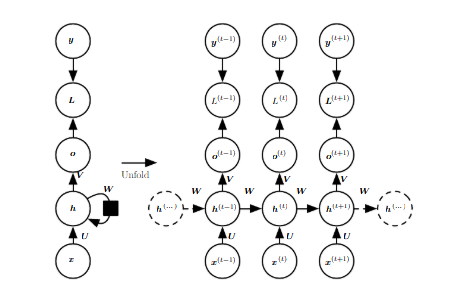

From http://www.deeplearningbook.org/contents/rnn.html

The following code comes with very slight modifications from "Minimal character-level Vanilla RNN model" by Andrej Karpathy (@karpathy):
*   https://gist.github.com/karpathy/d4dee566867f8291f086
*   http://karpathy.github.io/2015/05/21/rnn-effectiveness/

I really love this example because it's on the more approachable side for a beginner, it's convenient for the purposes of this workshop since we don't have time to explore Tensorflow/Keras, and it's informative since we can read through each chunk of code.  However, please don't feel as if you have to fully understand the content of each of the following code cells - we're just going to focus on concepts.

Let's start by inputting our raw corpus without any pre-processing:

In [ ]:
def data_input(corpus: list):
    
    """
    Takes a corpus as a list of strings
    Returns the data prepared to be used in a word-based model (rather than char-based model used by Andrej Karpathy)
    """
    
    data = '\n'.join(corpus)
    data = re.split('(\W)', data)
    words = list(set(data))
    vocab_size = len(words)
        
    return data, words, vocab_size

In [ ]:
data, words, vocab_size = data_input(corpus_texts)

print(data[:10])
print(words[:10])
print(vocab_size)

Next we'll create dictionaries that map words to IDs, and IDs to words:

In [ ]:
def gen_mapping(words_list: list) -> list:
    
    """
    Takes the prepared corpus data
    Returns dictionaries mapping the words to IDs, and IDs to words
    """
    
    word_to_ix = {ch: i for i, ch in enumerate(words_list)}
    ix_to_word = {i: ch for i, ch in enumerate(words_list)}
    
    return word_to_ix, ix_to_word

In [ ]:
word_to_ix, ix_to_word = gen_mapping(words)

print(word_to_ix['bee'])
print(ix_to_word[100])

Now we'll set our hyperparameters, which are defined prior to running the algorithm (as opposed to the model parameters, which are iteratively updated).  The learning rate is probably the most important hyperparameter to focus on, since it controls how much the weights are updated with each iteration.  A larger learning rate converges more quickly (perhaps overshooting minima), whereas a smaller learning rate converges more slowly (and may become stuck in a local minima).

In [ ]:
def set_hyperparams(hidden_size: int = 100, seq_length: int = 25, learning_rate: int = 1e-1) -> int:
    
    """
    Sets hyperparameters, defaulting to Andrej Karpathy's values
    """
    
    return hidden_size, seq_length, learning_rate

In [ ]:
hidden_size, seq_length, learning_rate = set_hyperparams()

print(hidden_size)
print(seq_length)
print(learning_rate)

Next we'll initialize placeholders for our model parameters:

In [ ]:
def set_model_params(hidden_size: int, vocab_size: int):
    
    """
    Sets model parameters based on hyperparameters and vocab size
    """
    
    Wxh = np.random.randn(hidden_size, vocab_size) * 0.01  # input to hidden
    Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # hidden to hidden
    Why = np.random.randn(vocab_size, hidden_size) * 0.01  # hidden to output
    bh = np.zeros((hidden_size, 1))  # hidden bias
    by = np.zeros((vocab_size, 1))  # output bias
    
    return Wxh, Whh, Why, bh, by

In [ ]:
Wxh, Whh, Why, bh, by = set_model_params(hidden_size, vocab_size)

print(Wxh)
print(Whh)
print(Why)
print(bh)
print(by)

We then perform the forward pass, update the loss, and perform the backward pass:

In [ ]:
def lossFun(inputs, targets, hprev):
    
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size, 1))  # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + bh)  # hidden state
        ys[t] = np.dot(Why, hs[t]) + by  # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))  # probabilities for next chars
        loss += -np.log(ps[t][targets[t], 0])  # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[
            t]] -= 1  # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext  # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh  # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t - 1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)  # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs) - 1]

This function returns a sample from the model at a given time:

In [ ]:
def sample(h, seed_ix, n):
    
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

And finally we have a function that iterates through the model and periodically returns a sample:

In [ ]:
def iterate_and_sample(sample_length: int = 200, sample_iters: int = 100, max_iters: int = 1000):
    
    """
    Putting it all together:
    Prints a model sample of a given length (default 200)
    at a given number of iterations (default 100)
    up to a maximum number of iterations (default 1000)
    """
    
    n, p = 0, 0
    mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    mbh, mby = np.zeros_like(bh), np.zeros_like(by)  # memory variables for Adagrad
    smooth_loss = -np.log(1.0 / vocab_size) * seq_length  # loss at iteration 0
    while n <= max_iters:
        # prepare inputs (we're sweeping from left to right in steps seq_length long)
        if p + seq_length + 1 >= len(data) or n == 0:
            hprev = np.zeros((hidden_size, 1))  # reset RNN memory
            p = 0  # go from start of data
        inputs = [word_to_ix[ch] for ch in data[p:p + seq_length]]
        targets = [word_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]]

        # sample from the model now and then
        if n % sample_iters == 0:
            sample_ix = sample(hprev, inputs[0], sample_length)
            txt = ''.join(ix_to_word[ix] for ix in sample_ix)
            print('----\n %s \n----' % (txt,))

        # forward seq_length characters through the net and fetch gradient
        loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        if n % sample_iters == 0: print('iter %d, loss: %f' % (n, smooth_loss))  # print progress

        # perform parameter update with Adagrad
        for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                      [dWxh, dWhh, dWhy, dbh, dby],
                                      [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

        p += seq_length  # move data pointer
        n += 1  # iteration counter

Here's our entire pipline put together:

In [ ]:
#load data:
data, words, vocab_size = data_input(corpus_texts)

#encode data:
word_to_ix, ix_to_word = gen_mapping(words)

#set hyperparameters
hidden_size, seq_length, learning_rate = set_hyperparams()

#set model parameters
Wxh, Whh, Why, bh, by = set_model_params(hidden_size, vocab_size)

#return model samples
iterate_and_sample()

These results look pretty decent, considering the very small size of our corpus!

# Exercises

These exercise prompts are meant to be starting points to encourage your own research and exploration. Choose whichever one(s) interest you most!

1. Use requests, BeautifulSoup, and the Wikipedia API to scrape a corpus of pages of your chosing. Here's a Python wrapper: https://pypi.org/project/Wikipedia-API/. Perform some preprocessing and make a few graphs.
2. Extend/modify our preprocessing function. Should it handle data in different formats? Should it perform stemming/lemmatization? 
3. Write your own function to generate n-grams, and graph the top n-grams for various n.
4. Write your own rules-based poetry generator. You could try using the parts of speech dictionaries, or NLTK's 'similar' words.
5. Try running the RNN after preprocessing our corpus, or try modifying the hyperparameters.
6. Train word2vec models (https://radimrehurek.com/gensim/models/word2vec.html) using our corpus, and look at word similarities.